<a href="https://colab.research.google.com/github/iguerrasevillano/TFM/blob/main/TLDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [52]:
!pip install datasets
!pip install rouge_score
!pip install huggingface_hub

In [54]:
# Libraries
import os
import pandas as pd
import numpy as np
import json

# Visualization
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split

# Keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# Transformers
from datasets import Dataset, DatasetDict, load_metric
from transformers import TFBartForConditionalGeneration, BartTokenizer, pipeline
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import AdamWeightDecay
from transformers.keras_callbacks import KerasMetricCallback
from transformers import PushToHubCallback

# NLTK
import nltk
nltk.download('punkt')

# AST
import ast

# Metrics
metric = load_metric('rouge')

# Current directory
os.getcwd()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


'/content'

In [2]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.0
    Uninstalling te

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


### Load and clean raw data

In [53]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
# Connect w/ Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
BASE_PATH = "/content/drive/MyDrive/VIU/TFM/Desarrollo/Data/"

documents = os.listdir(BASE_PATH)

In [31]:
# AUXILIAR FUNCTIONS

# Define a function to safely convert strings to lists
def convert_to_list(cell):
    try:
        return ast.literal_eval(cell)
    except (SyntaxError, ValueError):
        return cell

# Join all the sentences of source and target
def clean_data(data, column):
  data[column] = data[column].apply(lambda x : ' '.join(x))
  return data


def metric_fn(eval_predictions):
  predictions, labels = eval_predictions
  decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  for label in labels:
      label[label < 0] = tokenizer.pad_token_id  # Replace masked label tokens
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
  # Rouge expects a newline after each sentence
  decoded_predictions = [
      "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
  ]
  decoded_labels = [
      "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
  ]
  result = metric.compute(
      predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
  )
  # Extract a few results
  result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
  # Add mean generated length
  prediction_lens = [
      np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
  ]
  result["gen_len"] = np.mean(prediction_lens)

  return result

In [135]:
data = pd.read_csv(BASE_PATH+'Dev/Results/Extractive/extractive_summaries.csv')

data['source'] = data['source'].apply(convert_to_list)
data = clean_data(data, 'source')

data.sample(5)

,source,paper_id,target,title,number_words_target,extractive_summary
813,We introduce the deep abstaining classifier --...,rJxF73R9tX,A deep abstaining neural network trained with ...,Knows When it Doesn’t Know: Deep Abstaining Cl...,87,With the deployment of AI-based systems in hig...
181,There exists a plethora of techniques for indu...,HkG5JF6Do7,We extend a state-of-the-art technique to dire...,NaN,30,"However, to the best of our knowledge, none ta..."
303,Existing methods for AI-generated artworks sti...,BJe4V1HFPr,An adversarial training-based method for disen...,Disentangling Style and Content in Anime Illus...,65,"In addressing these challenges, we found that ..."
571,We investigate the robustness properties of im...,HylYtaVtwS,systematic study of large-scale cache-based im...,Improving the robustness of ImageNet classifie...,42,We show that to make the episodic memory more ...
117,Non-autoregressive machine translation (NAT) s...,BygFVAEKDH,We systematically examine why knowledge distil...,NaN,34,"Furthermore, a strong correlation is observed ..."


In [136]:
################
data = data[:100]
data.shape

(100, 6)

In [137]:
# Count number of words of source and target
def count_words(column):
  return data[column].apply(lambda x : len(x.split()))

data['number_words_target'] = count_words('target')
data['number_words_source'] = count_words('source')
data['number_words_extractive'] = count_words('extractive_summary')

In [138]:
print(data['number_words_target'].describe())
print(data['number_words_source'].describe())
print(data['number_words_extractive'].describe())

count    100.000000
mean      33.550000
std        4.388633
min       30.000000
25%       31.000000
50%       33.000000
75%       35.000000
max       68.000000
Name: number_words_target, dtype: float64
count      100.000000
mean      5361.200000
std       2477.611252
min        126.000000
25%       4020.750000
50%       5018.500000
75%       6431.250000
max      17169.000000
Name: number_words_source, dtype: float64
count     100.000000
mean      637.120000
std       145.607281
min       126.000000
25%       532.750000
50%       631.000000
75%       714.000000
max      1049.000000
Name: number_words_extractive, dtype: float64


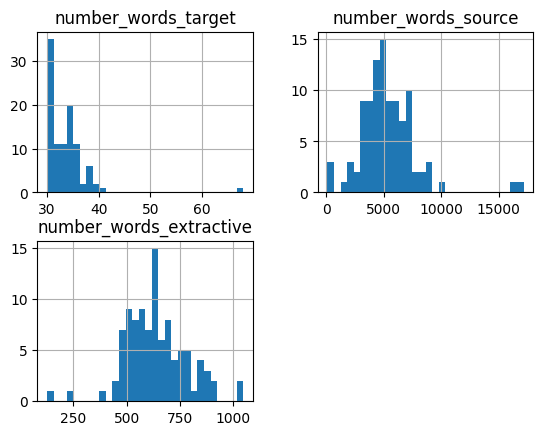

In [139]:
# Histogramas
data.hist(bins=30)
plt.show()

### BART



In [140]:
# Split data in different sets
data_training, data_test = train_test_split(data,
                                      test_size=0.20,
                                      random_state=42)

data_train, data_val = train_test_split(data_training,
                                        test_size=0.20,
                                        random_state=42)

In [141]:
print(data_train.shape, data_val.shape, data_training.shape, data_test.shape)

(64, 8) (16, 8) (80, 8) (20, 8)


In [142]:
# Convert all data to HF DatasetDict
tf_data_train = Dataset.from_pandas(data_train)
tf_data_test = Dataset.from_pandas(data_test)
tf_data_val = Dataset.from_pandas(data_val)

raw_data = DatasetDict({'train': tf_data_train,
                           'validation': tf_data_val,
                           'test': tf_data_test})

In [158]:
# Load BART Base-Model + Tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = TFAutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base')

max_new_tokens = 60
min_new_tokens = 40

model.generation_config.max_new_tokens = max_new_tokens
model.generation_config.min_new_tokens = min_new_tokens

model.config.attention_dropout = 0.3

print(model.generation_config)

All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "max_new_tokens": 60,
  "min_new_tokens": 40,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1
}



In [144]:
# Function in order to tokenize source and target
max_input_length = 1024

def tokenize_function(data):
  model_inputs = tokenizer(data['extractive_summary'], max_length=max_input_length, truncation=True, padding=True)

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(data['target'], padding=True)

  # The target input_ids tokens are added to the model inputs
  model_inputs['labels'] = labels['input_ids']
  return model_inputs

In [145]:
# Tokenize data
tokenized_data = raw_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [146]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['source', 'paper_id', 'target', 'title', 'number_words_target', 'extractive_summary', 'number_words_source', 'number_words_extractive', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 64
    })
    validation: Dataset({
        features: ['source', 'paper_id', 'target', 'title', 'number_words_target', 'extractive_summary', 'number_words_source', 'number_words_extractive', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 16
    })
    test: Dataset({
        features: ['source', 'paper_id', 'target', 'title', 'number_words_target', 'extractive_summary', 'number_words_source', 'number_words_extractive', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 20
    })
})

In [147]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np")

generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np")

In [148]:
batch_size = 8
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 1

In [149]:
train_dataset = model.prepare_tf_dataset(
    tokenized_data['train'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
    drop_remainder=False
)

validation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator
)

generation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=2*batch_size,
    shuffle=False,
    collate_fn=generation_data_collator
)

In [150]:
# Iterate through the dataset to inspect the batches
for batch in train_dataset.take(2):  # Take the first batch for inspection
    print(batch)

({'input_ids': <tf.Tensor: shape=(8, 1024), dtype=int64, numpy=
array([[    0, 13721,  2065, ...,     1,     1,     1],
       [    0,  9089, 15528, ...,     1,     1,     1],
       [    0,   170,   311, ...,     1,     1,     1],
       ...,
       [    0,  4148,     5, ...,     1,     1,     1],
       [    0,  1121,   645, ...,     1,     1,     1],
       [    0, 44466,   182, ...,     1,     1,     1]])>, 'attention_mask': <tf.Tensor: shape=(8, 1024), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'decoder_input_ids': <tf.Tensor: shape=(8, 86), dtype=int64, numpy=
array([[    2,     0,   170, 16217,   141,    10,  5808,  5448,     9,
        25206, 24176,   278, 33183,   417,  1033,    64,   258, 25762,
            8,  3594,    45,    95,    10,   881,  1380,    53,    41,
         1445,   278,     9,  

In [151]:
# Compile model
optimizer = AdamWeightDecay(
    learning_rate=learning_rate, weight_decay_rate=weight_decay
)

model.compile(optimizer=optimizer)

model.summary()

Model: "tf_bart_for_conditional_generation_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFBartMainLayer)     multiple                  139420416 
                                                                 
 final_logits_bias (BiasLay  multiple                  50265     
 er)                                                             
                                                                 
Total params: 139470681 (532.04 MB)
Trainable params: 139420416 (531.85 MB)
Non-trainable params: 50265 (196.35 KB)
_________________________________________________________________


In [152]:
BART_PATH = BASE_PATH + '/Desarrollo/Results/TLDR/BART'
#tensorboard_callback = TensorBoard(log_dir=BART_PATH+'/BART_model_save/logs')

metric_callback = KerasMetricCallback(
    metric_fn, eval_dataset=generation_dataset, predict_with_generate=True
)

push_to_hub_callback = PushToHubCallback(
    output_dir="./model_save",
    tokenizer=tokenizer,
    hub_model_id="iguerrasevillano/BART-summ-v1",
)

callbacks = [metric_callback, push_to_hub_callback]

# Train
print('[INFO: fine-tuning model...]')
H = model.fit(train_dataset, validation_data=validation_dataset, epochs=3, callbacks=callbacks)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/content/model_save is already a clone of https://huggingface.co/iguerrasevillano/BART-summ-v1. Make sure you pull the latest changes with `repo.git_pull()`.


[INFO: fine-tuning model...]
Epoch 1/3
8/8 [==============================] - 333s 40s/step - loss: 3.9172 - val_loss: 3.5170 - rouge1: 33.8243 - rouge2: 12.5847 - rougeL: 25.7183 - rougeLsum: 26.0936 - gen_len: 33.1250
Epoch 2/3
8/8 [==============================] - 273s 37s/step - loss: 3.3096 - val_loss: 3.5858 - rouge1: 29.0006 - rouge2: 8.6662 - rougeL: 22.8060 - rougeLsum: 22.8035 - gen_len: 29.8750
Epoch 3/3
8/8 [==============================] - 283s 39s/step - loss: 3.0257 - val_loss: 3.5285 - rouge1: 28.9739 - rouge2: 9.0105 - rougeL: 22.4322 - rougeLsum: 22.5583 - gen_len: 29.8750


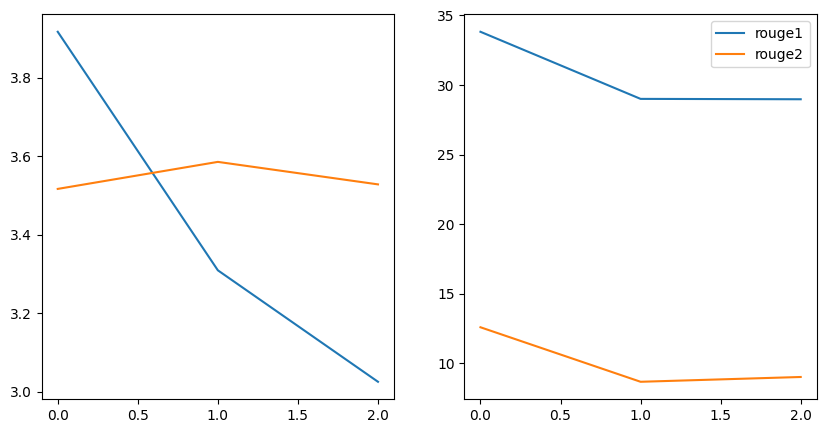

In [153]:
def plot_graphics(H):

    # Create a figure with 1 row and 2 columns, and set the figure size
    fig, ax = plt.subplots(1,2,figsize=(10,5))

    # Plot the training and validation loss for each epoch in the first subplot
    ax[0].plot(np.arange(0,len(H.history["loss"]) ), H.history["loss"], label="loss")
    ax[0].plot(np.arange(0,len(H.history["loss"])), H.history["val_loss"], label="val_loss")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge1"], label="rouge1")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge2"], label="rouge2")
    plt.legend()

plot_graphics(H)

In [154]:
print('[INFO]: generating tests summaries...')
generated_ids = model.generate(tokenized_data['test']['input_ids'])
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

[INFO]: generating tests summaries...


'We propose a deep neural network (BR-Net) that can learn features unbiased to bias variables.'

In [155]:
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[4]

'We propose a partial grounding approach to predict the probability of an operator to be in a plan.'

In [156]:
# Fine-tuned model Test
predicted_labels = np.array(generated_ids)
reference_labels = np.array(tokenized_data['test']['labels'])

metric_fn((predicted_labels, reference_labels))

{'rouge1': 34.042027339183015,
 'rouge2': 12.180135257521464,
 'rougeL': 24.50328674142886,
 'rougeLsum': 25.532805302971596,
 'gen_len': 27.3}

In [ ]:
# Pretrained model Test (check how results have improved)
pretrained_model = TFAutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base')

pretrained_model.generation_config.max_new_tokens = model.generation_config.max_new_tokens
pretrained_model.generation_config.min_new_tokens = model.generation_config.min_new_tokens

pretrained_generated_ids = pretrained_model.generate(tokenized_data['test']['input_ids'])
pretrained_predicted_labels = np.array(pretrained_generated_ids)

metric_fn((pretrained_predicted_labels, reference_labels))

All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


In [76]:
i = 5
print('ORIGINAL:' + tokenized_data['test']['target'][i])
print('FINE TUNED MODEL:' + tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[i])
print('PRETRAINED MODEL:' + tokenizer.batch_decode(pretrained_generated_ids, skip_special_tokens=True)[i])

ORIGINAL:Parametric adversarial divergences implicitly define more meaningful task losses for generative modeling, we make parallels with structured prediction to study the properties of these divergences and their ability to encode the task of interest.
FINE TUNED MODEL:We propose a framework to implicitly define parametric adversarial divergences for generative modeling, such as for generating "visually realistic" images. By relating GANs and structured prediction
PRETRAINED MODEL:Generative modeling of high dimensional data like images is a notoriously difficult and ill-defined problem. In particular, how to evaluate a learned generative model is unclear. In this paper, we


In [ ]:
tokenizer.model_max_length

1024